# Analyzing Training, Validation, and Testing Sets
Plotting some distributions of the test set.

In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
#from watchmal.testing.repeating_classifier_training_utils import *
from functools import reduce

from multiprocessing import Process, Pool
import boost_histogram as bh

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)

sys.path.append("../..")
sys.path.append("..")

from short_tank_exploratory_data_analysis.exploratory_data_analysis_utils import *

%load_ext autoreload
%matplotlib inline
%autoreload 2

from IPython.display import HTML

In [2]:
import boost_histogram

## Load Data

In [3]:
# Import test events from h5 file
filtered_index = "/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz"
filtered_indices = np.load(filtered_index, allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

original_data_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(original_data_path, "r")

hdf5_event_data = (f["event_data"])
original_eventdata = np.memmap(original_data_path, mode="r", shape=hdf5_event_data.shape,
                                    offset=hdf5_event_data.id.get_offset(), dtype=hdf5_event_data.dtype)

original_energies = np.array(f['energies'])
original_positions = np.array(f['positions'])
original_angles = np.array(f['angles'])
original_labels = np.array(f['labels'])

# filtered_eventdata = original_eventdata[test_filtered_indices]
test_energies = original_energies[test_filtered_indices]
test_positions = original_positions[test_filtered_indices]
test_angles = original_angles[test_filtered_indices]
test_labels = original_labels[test_filtered_indices]
f.close()

test_info = {'name':'Test Set','energies':test_energies,'positions':test_positions, 
             'angles':test_angles, 'labels':test_labels}

In [4]:
trainval_data_path='/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M_splits_CNN/IWCDmPMT_4pi_fulltank_9M_trainval.h5'
trainval_idxs_path='/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M_splits_CNN/IWCDmPMT_4pi_fulltank_9M_trainval_idxs.npz'

idxs = np.load(trainval_idxs_path,allow_pickle=True)
train_idxs = idxs['train_idxs']
val_idxs = idxs['val_idxs']

f = h5py.File(trainval_data_path,'r')
tv_hdf5_event_data = (f["event_data"])

tv_eventdata = np.memmap(trainval_data_path, mode="r", shape=tv_hdf5_event_data.shape,
                                    offset=tv_hdf5_event_data.id.get_offset(), dtype=tv_hdf5_event_data.dtype)

tv_energies = np.array(f['energies'])
tv_positions = np.array(f['positions'])
tv_angles = np.array(f['angles'])
tv_labels = np.array(f['labels'])

train_energies = tv_energies[train_idxs]
train_positions = tv_positions[train_idxs]
train_angles = tv_angles[train_idxs]
train_labels = tv_labels[train_idxs]

train_info = {'name':'Training Set','energies':train_energies,'positions':train_positions, 
              'angles':train_angles, 'labels':train_labels}

val_energies = tv_energies[val_idxs]
val_positions = tv_positions[val_idxs]
val_angles = tv_angles[val_idxs]
val_labels = tv_labels[val_idxs]
val_info = {'name':'Validation Set','energies':val_energies,'positions':val_positions, 
            'angles':val_angles, 'labels':val_labels}

In [5]:
dataset_info = [train_info,val_info,test_info]

# Specific Indexes

In [6]:
# Get dataset idxs by particle type
train_e_idxs = np.where(dataset_info[0]['labels']==1)[0]
val_e_idxs   = np.where(dataset_info[1]['labels']==1)[0]
test_e_idxs  = np.where(dataset_info[2]['labels']==1)[0]

train_g_idxs = np.where(dataset_info[0]['labels']==0)[0]
val_g_idxs   = np.where(dataset_info[1]['labels']==0)[0]
test_g_idxs  = np.where(dataset_info[2]['labels']==0)[0]

train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]
val_m_idxs   = np.where(dataset_info[1]['labels']==2)[0]
test_m_idxs  = np.where(dataset_info[2]['labels']==2)[0]

# Hit Charge Subset Construction

In [12]:
def get_event_PMTs(indices):
    pmt_charge = []
    pbar = ProgressBar(widgets=['Calculating PMT Charge for Validation Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
               ' ', ETA()], maxval=len(indices))

    pbar.start()
    for idx, i in enumerate(indices):
        pbar.update(idx)

        item = i #val_idxs[i]
        start = event_hits_index[item]
        stop  = event_hits_index[item + 1]
        charge = hit_charge[start:stop]
        #print(charge)
        pmt_charge.extend(charge)
        #print(pmt_charge[0])
        #input()
    pbar.finish()

    #dataset_info[1]['pmt_charge'] = np.array(pmt_charge)
    return np.array(pmt_charge)

In [13]:
"""
# Get random subsets of pmts by dataset and particle
N_subset_events = 10000

train_g_pmt_subset = get_event_PMTs(np.random.choice(train_g_idxs, size=N_subset_events, replace=False))
val_g_pmt_subset   = get_event_PMTs(np.random.choice(val_g_idxs, size=N_subset_events, replace=False))
test_g_pmt_subset  = get_event_PMTs(np.random.choice(test_g_idxs, size=N_subset_events, replace=False))

train_e_pmt_subset = get_event_PMTs(np.random.choice(train_e_idxs, size=N_subset_events, replace=False))
val_e_pmt_subset   = get_event_PMTs(np.random.choice(val_e_idxs, size=N_subset_events, replace=False))
test_e_pmt_subset  = get_event_PMTs(np.random.choice(test_e_idxs, size=N_subset_events, replace=False))

train_m_pmt_subset = get_event_PMTs(np.random.choice(train_m_idxs, size=N_subset_events, replace=False))
val_m_pmt_subset   = get_event_PMTs(np.random.choice(val_m_idxs, size=N_subset_events, replace=False))
test_m_pmt_subset  = get_event_PMTs(np.random.choice(test_m_idxs, size=N_subset_events, replace=False))
"""

'\n# Get random subsets of pmts by dataset and particle\nN_subset_events = 10000\n\ntrain_g_pmt_subset = get_event_PMTs(np.random.choice(train_g_idxs, size=N_subset_events, replace=False))\nval_g_pmt_subset   = get_event_PMTs(np.random.choice(val_g_idxs, size=N_subset_events, replace=False))\ntest_g_pmt_subset  = get_event_PMTs(np.random.choice(test_g_idxs, size=N_subset_events, replace=False))\n\ntrain_e_pmt_subset = get_event_PMTs(np.random.choice(train_e_idxs, size=N_subset_events, replace=False))\nval_e_pmt_subset   = get_event_PMTs(np.random.choice(val_e_idxs, size=N_subset_events, replace=False))\ntest_e_pmt_subset  = get_event_PMTs(np.random.choice(test_e_idxs, size=N_subset_events, replace=False))\n\ntrain_m_pmt_subset = get_event_PMTs(np.random.choice(train_m_idxs, size=N_subset_events, replace=False))\nval_m_pmt_subset   = get_event_PMTs(np.random.choice(val_m_idxs, size=N_subset_events, replace=False))\ntest_m_pmt_subset  = get_event_PMTs(np.random.choice(test_m_idxs, size=N

In [14]:
"""
np.savez('./new_dataset_data/training_set_pmt_charge.npz', train_g_pmt_subset=train_g_pmt_subset,
                                                           train_e_pmt_subset=train_e_pmt_subset,
                                                           train_m_pmt_subset=train_m_pmt_subset)

np.savez('./new_dataset_data/validation_set_pmt_charge.npz', val_g_pmt_subset=val_g_pmt_subset,
                                                             val_e_pmt_subset=val_e_pmt_subset,
                                                             val_m_pmt_subset=val_m_pmt_subset)

np.savez('./new_dataset_data/test_set_pmt_charge.npz',  test_g_pmt_subset=test_g_pmt_subset,
                                                        test_e_pmt_subset=test_e_pmt_subset,
                                                        test_m_pmt_subset=test_m_pmt_subset)
"""

"\nnp.savez('./new_dataset_data/training_set_pmt_charge.npz', train_g_pmt_subset=train_g_pmt_subset,\n                                                           train_e_pmt_subset=train_e_pmt_subset,\n                                                           train_m_pmt_subset=train_m_pmt_subset)\n\nnp.savez('./new_dataset_data/validation_set_pmt_charge.npz', val_g_pmt_subset=val_g_pmt_subset,\n                                                             val_e_pmt_subset=val_e_pmt_subset,\n                                                             val_m_pmt_subset=val_m_pmt_subset)\n\nnp.savez('./new_dataset_data/test_set_pmt_charge.npz',  test_g_pmt_subset=test_g_pmt_subset,\n                                                        test_e_pmt_subset=test_e_pmt_subset,\n                                                        test_m_pmt_subset=test_m_pmt_subset)\n"

In [15]:
# Load random subsets of pmts by dataset and particle
train_subsets = np.load('./new_dataset_data/training_set_pmt_charge.npz')
val_subsets = np.load('./new_dataset_data/validation_set_pmt_charge.npz')
test_subsets = np.load('./new_dataset_data/test_set_pmt_charge.npz')

train_g_pmt_subset = train_subsets['train_g_pmt_subset']
val_g_pmt_subset   = val_subsets['val_g_pmt_subset']
test_g_pmt_subset  = test_subsets['test_g_pmt_subset']

train_e_pmt_subset = train_subsets['train_e_pmt_subset']
val_e_pmt_subset   = val_subsets['val_e_pmt_subset']
test_e_pmt_subset  = test_subsets['test_e_pmt_subset']

train_m_pmt_subset = train_subsets['train_m_pmt_subset']
val_m_pmt_subset   = val_subsets['val_m_pmt_subset']
test_m_pmt_subset  = test_subsets['test_m_pmt_subset']


No handles with labels found to put in legend.


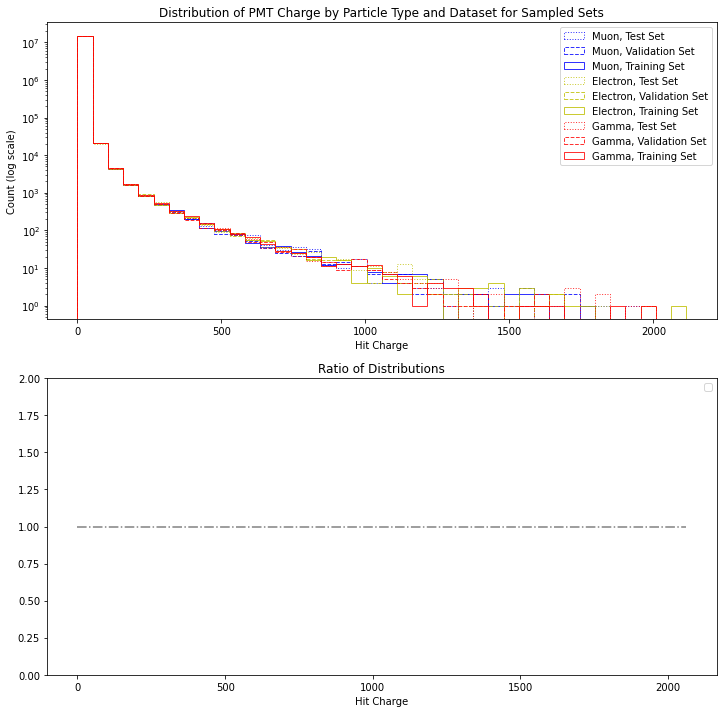

In [16]:
fig = plot_compare_dists([train_g_pmt_subset, val_g_pmt_subset, test_g_pmt_subset, 
                          train_e_pmt_subset, val_e_pmt_subset, test_e_pmt_subset,
                          train_m_pmt_subset, val_m_pmt_subset, test_m_pmt_subset],
                         numerator_dist_idxs   = [],
                         denominator_dist_idxs = [],
                         labels=[
                                  'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                                  'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                                  'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                         bins=40,
                         ratio_range=[0,2],
                         title='Distribution of PMT Charge by Particle Type and Dataset for Sampled Sets', 
                         colors =  ['r','r','r','y','y','y','b','b','b'],
                         linestyle=['-','--',':','-','--',':','-','--',':'],
                         normalized=False,
                         yscale='log',
                         xlabel='Hit Charge'
                    )


# Plot Lowest Range

In [17]:
lowest_range_bins = np.linspace(5.0754726e-02, 3.6431072e+00, 40)

No handles with labels found to put in legend.


Bins:  [0.05075473 0.14286633 0.23497793 0.32708953 0.41920113 0.51131274
 0.60342434 0.69553594 0.78764754 0.87975914 0.97187074 1.06398235
 1.15609395 1.24820555 1.34031715 1.43242875 1.52454036 1.61665196
 1.70876356 1.80087516 1.89298676 1.98509837 2.07720997 2.16932157
 2.26143317 2.35354477 2.44565638 2.53776798 2.62987958 2.72199118
 2.81410278 2.90621438 2.99832599 3.09043759 3.18254919 3.27466079
 3.36677239 3.458884   3.5509956  3.6431072 ]


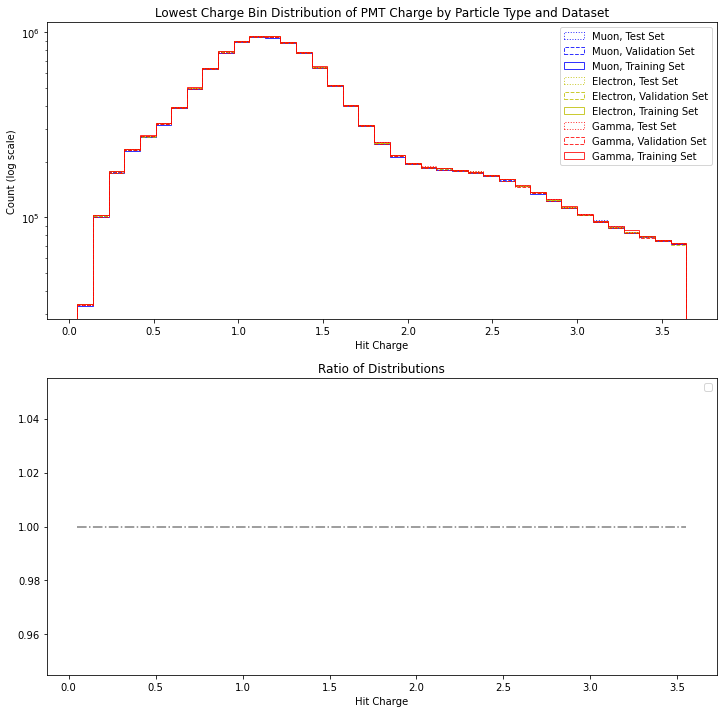

In [18]:
fig = plot_compare_dists([train_g_pmt_subset, val_g_pmt_subset, test_g_pmt_subset, 
                          train_e_pmt_subset, val_e_pmt_subset, test_e_pmt_subset,
                          train_m_pmt_subset, val_m_pmt_subset, test_m_pmt_subset],
                         numerator_dist_idxs   = [],
                         denominator_dist_idxs = [],
                         labels=[
                                  'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                                  'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                                  'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                         bins=lowest_range_bins,
                         title='Lowest Charge Bin Distribution of PMT Charge by Particle Type and Dataset', 
                         colors =  ['r','r','r','y','y','y','b','b','b'],
                         linestyle=['-','--',':','-','--',':','-','--',':'],
                         normalized=False,
                         yscale='log',
                         xlabel='Hit Charge',
                         verbose=True
                    )

# Boost Histogram Example

In [19]:
hist = bh.Histogram(
    bh.axis.Regular(2, train_g_pmt_subset[0:5].min(), train_g_pmt_subset[0:5].max())
)

hist.fill(train_g_pmt_subset[0:5])

print(hist.to_numpy())

(array([3., 1.]), array([ 1.1411258 ,  6.73413044, 12.32713509]))


In [20]:
"""
# Compare plotting performance
time0 = time.time()
#plt.hist(hit_charge[0:100000000], histtype='step')
#print(np.histogram(hit_charge[0:1000000000], bins=40))

hist = bh.Histogram(
    bh.axis.Regular(40, hit_charge[0:10000000000].min(), hit_charge[0:10000000000].max())
)
hist.fill(hit_charge[0:10000000000], threads=16)
print(hist.to_numpy())

#print(np.histogram(hit_charge[0:10000000]))
time1 = time.time()
print(time1 - time0)
"""

"\n# Compare plotting performance\ntime0 = time.time()\n#plt.hist(hit_charge[0:100000000], histtype='step')\n#print(np.histogram(hit_charge[0:1000000000], bins=40))\n\nhist = bh.Histogram(\n    bh.axis.Regular(40, hit_charge[0:10000000000].min(), hit_charge[0:10000000000].max())\n)\nhist.fill(hit_charge[0:10000000000], threads=16)\nprint(hist.to_numpy())\n\n#print(np.histogram(hit_charge[0:10000000]))\ntime1 = time.time()\nprint(time1 - time0)\n"

# Subset Hit Charge by PMT

In [21]:
"Load subset data to get bins"
training_subsets = np.load('./new_dataset_data/training_set_pmt_charge.npz',allow_pickle=True) 
validation_subsets = np.load('./new_dataset_data/validation_set_pmt_charge.npz',allow_pickle=True)
test_subsets = np.load('./new_dataset_data/test_set_pmt_charge.npz',allow_pickle=True)

# Get random subsets of pmts by dataset and particle
N_subset_events = 1000

train_g_pmt_subset = training_subsets['train_g_pmt_subset']
val_g_pmt_subset   = validation_subsets['val_g_pmt_subset']
test_g_pmt_subset  = test_subsets['test_g_pmt_subset']

train_e_pmt_subset = training_subsets['train_e_pmt_subset']
val_e_pmt_subset   = validation_subsets['val_e_pmt_subset']
test_e_pmt_subset  = test_subsets['test_e_pmt_subset']

train_m_pmt_subset = training_subsets['train_m_pmt_subset']
val_m_pmt_subset   = validation_subsets['val_m_pmt_subset']
test_m_pmt_subset  = test_subsets['test_m_pmt_subset']


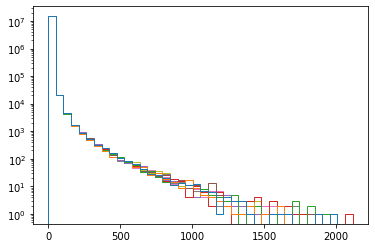

In [22]:
__, subset_plot_bins, __ = plt.hist([train_g_pmt_subset, val_g_pmt_subset, test_g_pmt_subset, 
                              train_e_pmt_subset, val_e_pmt_subset, test_e_pmt_subset,
                              train_m_pmt_subset, val_m_pmt_subset, test_m_pmt_subset],
                             histtype=u'step',
                             bins=40)
plt.yscale('log')
#plot_bins = np.logspace(np.log10(plot_bins[0]), np.log10(plot_bins[-1]), 40 + 1)

In [31]:
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm_notebook as tqdm

def get_large_hist(pos, indices, bins, name):
    #TODO: Until tqdm in the docker image is updated, this print statement appears to be required
    print('')
    pmt_charge = []
    description = '{} Progress: '.format(name)
    
    hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1]))#, growth=True))
    for i in tqdm(indices, desc=description, position=pos):
        item = i
        start = event_hits_index[item]
        stop  = event_hits_index[item + 1]
        hit_data = hit_charge[start:stop]

        hist.fill(hit_data)

    return hist.to_numpy()

In [24]:
from multiprocessing import Process, Pool
# Get multiple progress bars
# Get return values of all processes
test_train_e_idxs = train_e_idxs
test_train_g_idxs = train_g_idxs

def get_large_hists(input_sets, bins, names):
    pool = Pool(len(input_sets))
    arg_list = [(idx, item, bins, name) for idx, (item, name) in enumerate(zip(input_sets, names))]
    result_hists, result_bins = zip(*pool.starmap(get_large_hist, arg_list))
    return result_hists, result_bins

In [25]:
test_large_plot_inputs = [test_train_g_idxs[0:100000], test_train_e_idxs[0:100000]]
test_large_plot_names = ['train_g', 'train_e']

test_hists, test_bins = get_large_hists(test_large_plot_inputs, plot_bins, test_large_plot_names)

NameError: name 'plot_bins' is not defined

In [ ]:
from short_tank_exploratory_data_analysis.exploratory_data_analysis_utils import plot_computed_dists

plot_computed_dists(test_hists, 
                    bins=test_bins,
                    numerator_dist_idxs   = [1],
                    denominator_dist_idxs = [0],
                    labels=['Gamma, Validation Set', 'Electron, Training Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Charge by Particle Type and Dataset', 
                    colors =  ['r','y'],
                    linestyle=['-','-'],
                    yscale='log',
                    xlabel='Hit Charge'
                   )

# Hit Charge by PMT

In [26]:
large_plot_inputs = [train_g_idxs, val_g_idxs, test_g_idxs,
                     train_e_idxs, val_e_idxs, test_e_idxs,
                     train_m_idxs, val_m_idxs, test_m_idxs,]

In [ ]:
"""
max_charge = np.max(hit_charge)
print(max_charge)
"""

In [ ]:
#plot_bins = np.logspace(np.log10(subset_plot_bins[0]), np.log10(max_charge), 40 + 1)

In [27]:
plot_bins = subset_plot_bins

In [30]:
# Get hist data for full dataset
large_plot_inputs = [train_g_idxs, val_g_idxs, test_g_idxs,
                     train_e_idxs, val_e_idxs, test_e_idxs,
                     train_m_idxs, val_m_idxs, test_m_idxs,]

large_plot_names = ['train_g', 'val_g', 'test_g',
                    'train_e', 'val_e', 'test_e',
                    'train_m', 'val_m', 'test_m']

outputs = get_large_hists(large_plot_inputs, plot_bins, large_plot_names)

In [ ]:
# Plot overall distribution
plot_computed_dists(outputs[0], 
                    bins=outputs[1],
                    numerator_dist_idxs   = [],
                    denominator_dist_idxs = [],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Charge by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'],
                    normalized=False,
                    yscale='log',
                    xlabel='Hit Charge'
                   )

In [ ]:
# Plot overall distribution normalized
plot_computed_dists(outputs[0], 
                    bins=outputs[1],
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Charge by Particle Type and Dataset (Normalized)',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    yscale='log',
                    xlabel='Hit Charge'
                   )

In [ ]:
lowest_range_bins = np.linspace(plot_bins[0], plot_bins[1], 40)
lowest_hists, lowest_bins = get_large_hists(large_plot_inputs, lowest_range_bins, large_plot_names)

In [ ]:
# Plot left tail
plot_computed_dists(lowest_hists, 
                    bins=lowest_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    title='Left of Distribution of PMT Charge by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    yscale='log',
                    xlabel='Hit Charge'
                   )

In [ ]:
# Get very small values
lowest_range_bins = np.linspace(5.0754726e-02, 3.6431072e+00, 40)
lowest_hists, lowest_bins = get_large_hists(large_plot_inputs, lowest_range_bins, large_plot_names)

In [ ]:
# Plot very small values
plot_computed_dists(lowest_hists, 
                    bins=lowest_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    title='Center of Distribution of PMT Charge by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    yscale='log',
                    xlabel='Hit Charge'
                   )

# Hit Times Subset Construction

In [35]:
def get_event_hit_times(indices):
    pmt_times = []
    pbar = ProgressBar(widgets=['Calculating PMT Charge for Validation Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
               ' ', ETA()], maxval=len(indices))

    pbar.start()
    for idx, i in enumerate(indices):
        pbar.update(idx)

        item = i #val_idxs[i]
        event_data = tv_eventdata[item]
        times = event_data[:, :, 19:]
        pmt_times.extend(times)
    pbar.finish()

    #dataset_info[1]['pmt_charge'] = np.array(pmt_charge)
    return np.array(pmt_times)

In [47]:

# Get random subsets of pmts by dataset and particle
N_subset_events = 10000

train_g_times_subset = get_event_hit_times(np.random.choice(train_g_idxs, size=N_subset_events, replace=False)).flatten()
val_g_times_subset   = get_event_hit_times(np.random.choice(val_g_idxs, size=N_subset_events, replace=False)).flatten()

train_e_times_subset = get_event_hit_times(np.random.choice(train_e_idxs, size=N_subset_events, replace=False)).flatten()
val_e_times_subset   = get_event_hit_times(np.random.choice(val_e_idxs, size=N_subset_events, replace=False)).flatten()

train_m_times_subset = get_event_hit_times(np.random.choice(train_m_idxs, size=N_subset_events, replace=False)).flatten()
val_m_times_subset   = get_event_hit_times(np.random.choice(val_m_idxs, size=N_subset_events, replace=False)).flatten()



Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:06
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:02
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:01
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:01
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:02
Calculating PMT Charge for Validation Set. Progress: 100% [00000] Time: 0:00:02


In [49]:
"""
np.savez('./old_dataset_data/training_set_times_subset.npz', train_g_times_subset=train_g_times_subset,
                                                           train_e_times_subset=train_e_times_subset,
                                                           train_m_times_subset=train_m_times_subset)

np.savez('./old_dataset_data/validation_times_subset.npz', val_g_times_subset=val_g_times_subset,
                                                             val_e_times_subset=val_e_times_subset,
                                                             val_m_times_subset=val_m_times_subset)
"""

In [7]:
training_times_subset = np.load('./old_dataset_data/training_set_times_subset.npz',allow_pickle=True) 
validation_times_subset = np.load('./old_dataset_data/validation_times_subset.npz',allow_pickle=True)

train_g_times_subset = training_times_subset['train_g_times_subset']
val_g_times_subset   = validation_times_subset['val_g_times_subset']

train_e_times_subset = training_times_subset['train_e_times_subset']
val_e_times_subset   = validation_times_subset['val_e_times_subset']

train_m_times_subset = training_times_subset['train_m_times_subset']
val_m_times_subset   = validation_times_subset['val_m_times_subset']


In [23]:
print(train_g_times_subset.shape)

(400000, 40, 19)


No handles with labels found to put in legend.


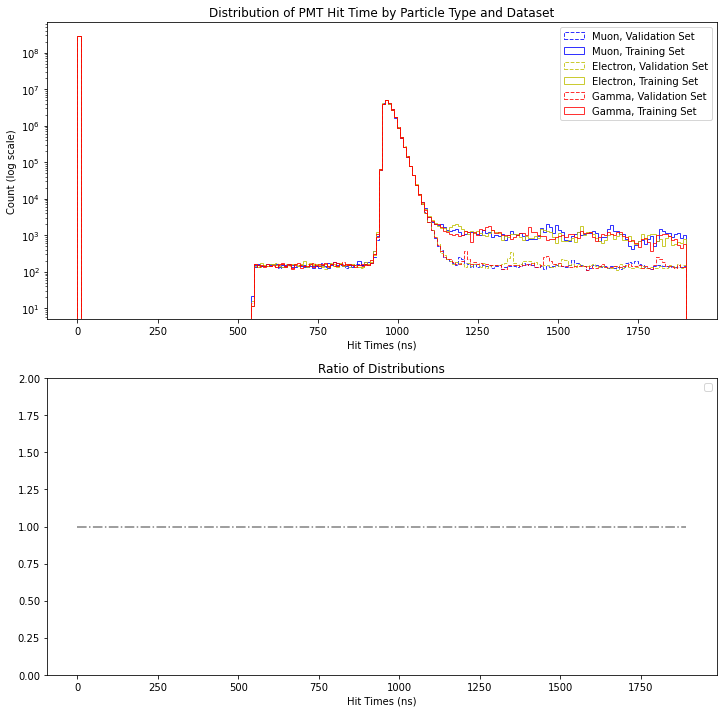

In [8]:
fig = plot_compare_dists([train_g_times_subset, val_g_times_subset, 
                          train_e_times_subset, val_e_times_subset,
                          train_m_times_subset, val_m_times_subset],
                         numerator_dist_idxs   = [],
                         denominator_dist_idxs = [],
                         labels=[
                                  'Gamma, Training Set', 'Gamma, Validation Set',
                                  'Electron, Training Set', 'Electron, Validation Set',
                                  'Muon, Training Set', 'Muon, Validation Set' ],
                         bins=200,
                         ratio_range=[0,2],
                         title='Distribution of PMT Hit Time by Particle Type and Dataset', 
                         colors =  ['r','r','y','y','b','b'],
                         linestyle=['-','--','-','--','-','--'], 
                         normalized=False,
                         yscale='log',
                         xlabel='Hit Times (ns)'
                    )

# Hit Times

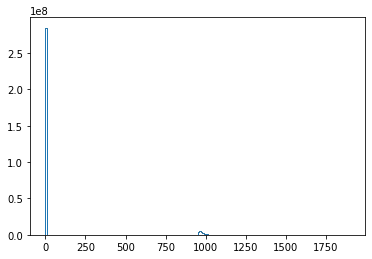

In [9]:
ns, time_plot_bins, __ = plt.hist([train_g_times_subset, val_g_times_subset, 
                              train_e_times_subset, val_e_times_subset,
                              train_m_times_subset, val_m_times_subset],
                             histtype=u'step',
                             bins=200)

In [11]:
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm_notebook as tqdm

def get_large_times_hist(pos, indices, bins, name):
    #TODO: Until tqdm in the docker image is updated, this print statement appears to be required
    print('')
    pmt_charge = []
    description = '{} Progress: '.format(name)
    
    hist = bh.Histogram(bh.axis.Regular(len(bins) - 1, bins[0], bins[-1]))#, growth=True))
    for i in tqdm(indices, desc=description, position=pos):
        item = i
        event_data = tv_eventdata[item]
        times = event_data[:, :, 19:].flatten()
        hist.fill(times[np.nonzero(times)])

    return hist.to_numpy()

In [12]:
def get_large_times_hists(input_sets, bins, names):
    pool = Pool(len(input_sets))
    arg_list = [(idx, item, bins, name) for idx, (item, name) in enumerate(zip(input_sets, names))]
    result_hists, result_bins = zip(*pool.starmap(get_large_times_hist, arg_list))
    return result_hists, result_bins

In [ ]:
#from tqdm import tqdm_notebook as tqdm
"""
from tqdm import tqdm_notebook as tqdm

def get_large_times_hist(pos, indices, bins, name):
    #TODO: Until tqdm in the docker image is updated, this print statement appears to be required
    print('')
    pmt_charge = []
    
    hist = np.zeros(len(bins)-1)
    description = '{} Progress: '.format(name)
    for i in tqdm(indices, desc=description, position=pos):
        item = i
        start = event_hits_index[item]
        stop  = event_hits_index[item + 1]
        hit_data = hit_time[start:stop]

        temp_hist, _ = np.histogram(np.clip(hit_data, bins[0], bins[-1]), bins)
        hist += temp_hist

    return hist

def get_large_times_hists(input_sets, bins, names):
    pool = Pool(len(input_sets))
    arg_list = [(idx, item, bins, name) for idx, (item, name) in enumerate(zip(input_sets, names))]
    results = pool.starmap(get_large_times_hist, arg_list)
    return results
"""

In [13]:
test_time_large_plot_inputs = [val_g_idxs[0:1000], val_e_idxs[0:1000]]
test_time_large_plot_names = ['train_g', 'train_e']

test_time_hists, test_time_bins = get_large_times_hists(test_time_large_plot_inputs, time_plot_bins, test_time_large_plot_inputs)

No handles with labels found to put in legend.


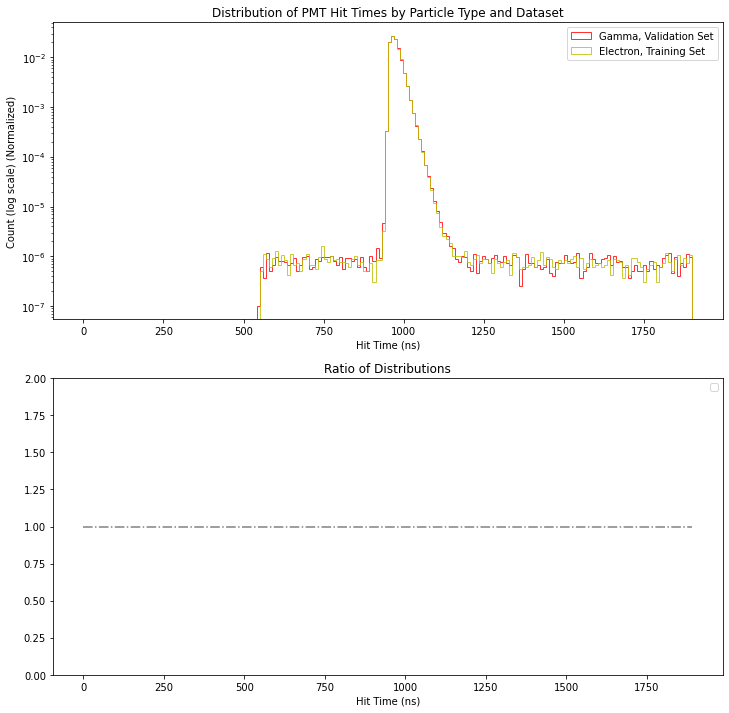

In [14]:
plot_computed_dists(test_time_hists, 
                    bins=test_time_bins,
                    numerator_dist_idxs   = [],
                    denominator_dist_idxs = [],
                    labels=['Gamma, Validation Set', 'Electron, Training Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Hit Times by Particle Type and Dataset', 
                    colors =  ['r','y'],
                    linestyle=['-','-'], 
                    yscale='log',
                    xlabel='Hit Time (ns)'
                   )

In [16]:
# Get hist data for full dataset
time_large_plot_inputs = [train_g_idxs, val_g_idxs,
                     train_e_idxs, val_e_idxs,
                     train_m_idxs, val_m_idxs,]

time_large_plot_names = ['train_g', 'val_g',
                    'train_e', 'val_e',
                    'train_m', 'val_m']

#time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, time_plot_bins, time_large_plot_names)

No handles with labels found to put in legend.


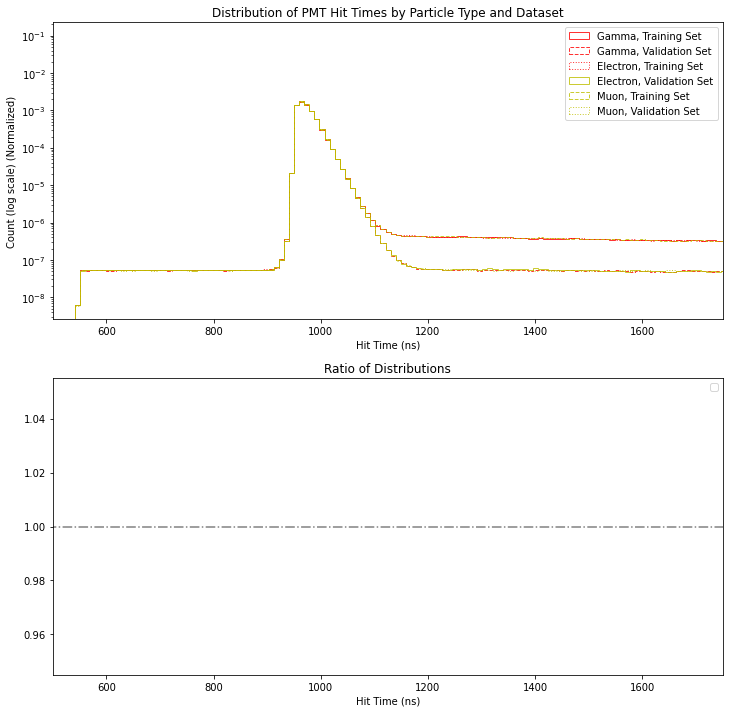

In [69]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [],
                    denominator_dist_idxs = [],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set',
                            'Electron, Training Set', 'Electron, Validation Set',
                            'Muon, Training Set', 'Muon, Validation Set'],
                    title='Distribution of PMT Hit Times by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'],
                    xrange=[500, 1750],
                    yscale='log',
                    xlabel='Hit Time (ns)'
                   )

In [39]:
# Left tail
left_time_bins = np.linspace(time_plot_bins[0], 900., 100)
time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, left_time_bins, time_large_plot_names)

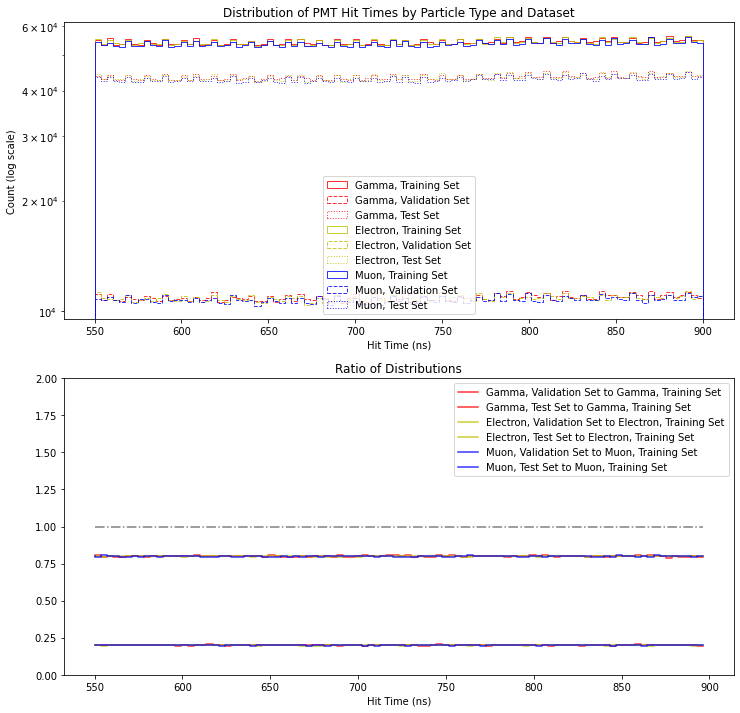

In [40]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Hit Times by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    xlabel='Hit Time (ns)',
                    normalized=False,
                    yscale='log',
                    loc='lower center'
                   )

In [17]:
# Extra zoomed in left bin
left_time_bins = np.linspace(650, 700., 100)

time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, left_time_bins, time_large_plot_names)

In [76]:
print("5")

No handles with labels found to put in legend.


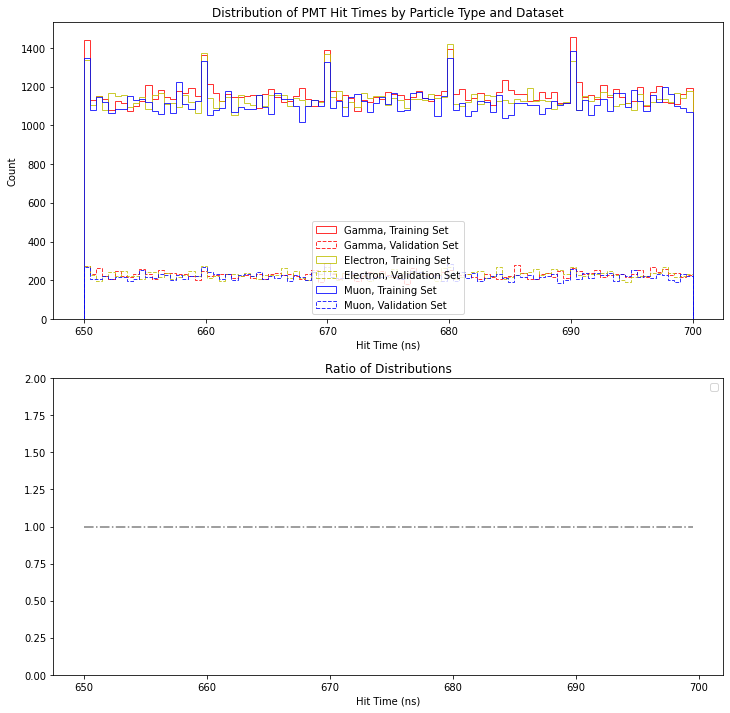

In [18]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [],
                    denominator_dist_idxs = [],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set',
                            'Electron, Training Set', 'Electron, Validation Set',
                            'Muon, Training Set', 'Muon, Validation Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Hit Times by Particle Type and Dataset',  
                    colors =  ['r','r',
                               'y','y',
                               'b','b'],
                    linestyle=['-','--',
                               '-','--',
                               '-','--'], 
                    xlabel='Hit Time (ns)',
                    normalized=False,
                    yscale='linear',
                    loc='lower center'
                   )

In [ ]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [3, 6],
                    denominator_dist_idxs = [0, 0],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    title='Distribution of PMT Hit Times by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    xlabel='Hit Time (ns)',
                    yscale='log',
                    loc='lower center'
                   )

In [ ]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    title='Distribution of PMT Hit Times by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    xlabel='Hit Time (ns)',
                    yscale='log',
                    loc='lower center'
                   )

In [49]:
# Middle
middle_time_bins = np.linspace(950, 1050, 100)
time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, middle_time_bins, time_large_plot_names)

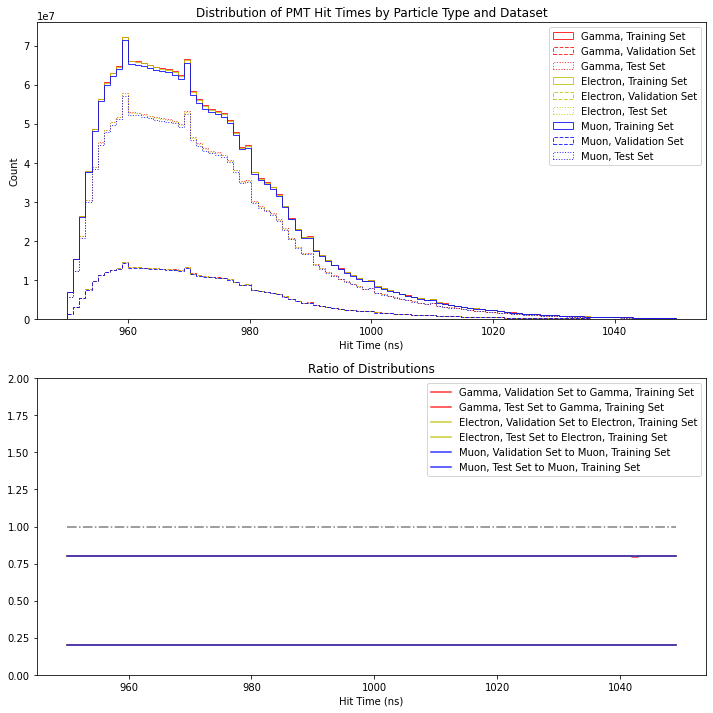

In [51]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Hit Times by Particle Type and Dataset', 
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'],
                    normalized=False,
                    yscale='linear',                    
                    xlabel='Hit Time (ns)',

                   )

In [ ]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    title='Distribution of PMT Hit Times by Particle Type and Dataset', 
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    yscale='log',                    
                    xlabel='Hit Time (ns)',

                   )

In [ ]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [3, 6],
                    denominator_dist_idxs = [0, 0],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    title='Distribution of PMT Hit Times by Particle Type and Dataset', 
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'],
                    yscale='log',                    
                    xlabel='Hit Time (ns)',

                   )

In [ ]:
# Zoomed Middle
middle_time_bins = np.linspace(900, 1200, 100)
time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, middle_time_bins, time_large_plot_names)

In [44]:
# Right tail
right_time_bins = np.linspace(1200, time_plot_bins[-1], 100)
time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, right_time_bins, time_large_plot_names)

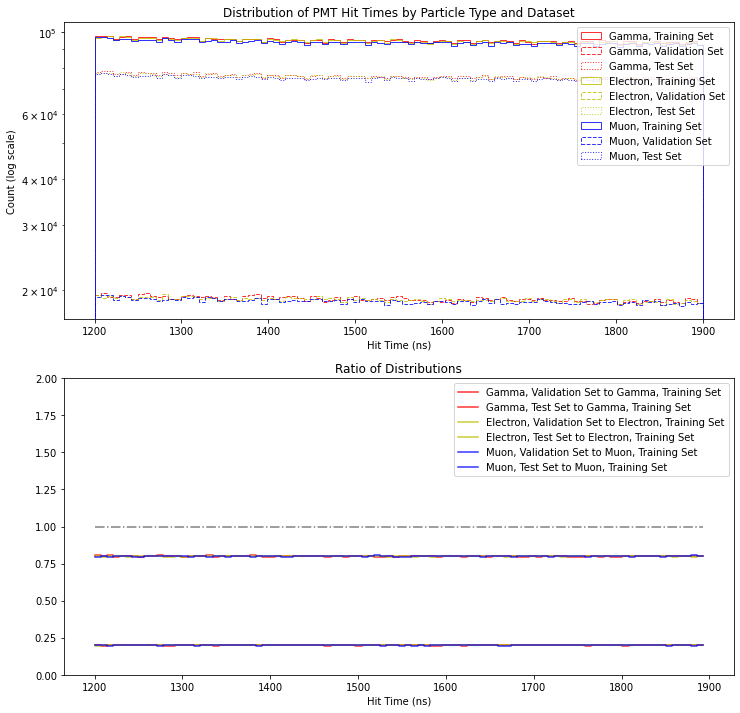

In [45]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Hit Times by Particle Type and Dataset', 
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'],
                    normalized=False,
                    yscale='log',                    
                    xlabel='Hit Time (ns)',
                   )

In [46]:
# Zoomed Right tail
right_time_bins = np.linspace(1200, 1300, 100)
time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, right_time_bins, time_large_plot_names)

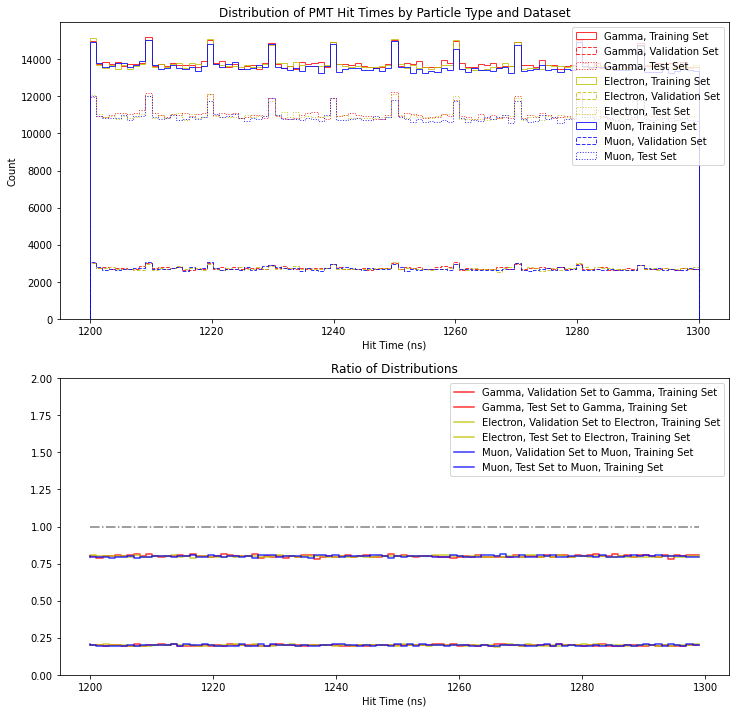

In [48]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Hit Times by Particle Type and Dataset', 
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'],
                    normalized=False,
                    yscale='linear',                    
                    xlabel='Hit Time (ns)',
                   )

In [ ]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    title='Distribution of PMT Hit Times by Particle Type and Dataset', 
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    yscale='log',                    
                    xlabel='Hit Time (ns)',
                   )

In [ ]:
# focused on peak
peak_time_bins = np.linspace(940, 1100, 100)
time_hists, time_bins = get_large_times_hists(time_large_plot_inputs, peak_time_bins, time_large_plot_names)

In [ ]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Hit Times by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'],
                    normalized=False,
                    yscale='log',                    
                    xlabel='Hit Time (ns)',
                   )

In [ ]:
plot_computed_dists(time_hists, 
                    bins=time_bins,
                    numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                    denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                    labels=[
                            'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                            'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                            'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                    ratio_range=[0,2],
                    title='Distribution of PMT Hit Times by Particle Type and Dataset',  
                    colors =  ['r','r','r',
                               'y','y','y',
                               'b','b','b'],
                    linestyle=['-','--',':',
                               '-','--',':',
                               '-','--',':'], 
                    yscale='log',                    
                    xlabel='Hit Time (ns)',
                   )